<a href="https://colab.research.google.com/github/davidcamilo0710/QATAR_2022_Prediction/blob/master/QATAR22_EDA%2BData_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INDEX
- ANALYZING INTERNATIONAL MATCHES
- CREATING TRAINING DATASET



# ANALYZING INTERNATIONAL MATCHES


In [42]:
#PYSPARK installation
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys

import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("FIFA 2026 ANALYSIS") \
       .getOrCreate()

spark

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (137 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open:

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pyspark.sql.functions import col, rank, first, to_date, row_number, when, date_format, year, expr, min, max, count, lit, round, sum, mean, round, udf
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DateType, FloatType
warnings.filterwarnings('ignore')

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Read the CSV file
df = spark.read.csv('/content/drive/MyDrive/Big Data/Data/international_matches.csv', header=True, inferSchema=True)

# Convert to the desired format
df = df.withColumn("date", date_format(col("date"), "yyyy/MM/dd"))

# Show the results
df.show()

+----------+-------------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+------------+-------------+----------------+---------+----------------+--------------------------+--------------------------+----------------------------+----------------------------+-----------------------------+----------------------------+----------------------------+-----------------------------+
|      date|    home_team|   away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|        city|      country|neutral_location|shoot_out|home_team_result|home_team_goalkeeper_score|away_team_goalkeeper_score|home_team_mean_defense_score|home_team_mean_offense_score|home_team_mean_midfield_score|away_team_mean_defense_score|

In [46]:
df.columns

['date',
 'home_team',
 'away_team',
 'home_team_continent',
 'away_team_continent',
 'home_team_fifa_rank',
 'away_team_fifa_rank',
 'home_team_total_fifa_points',
 'away_team_total_fifa_points',
 'home_team_score',
 'away_team_score',
 'tournament',
 'city',
 'country',
 'neutral_location',
 'shoot_out',
 'home_team_result',
 'home_team_goalkeeper_score',
 'away_team_goalkeeper_score',
 'home_team_mean_defense_score',
 'home_team_mean_offense_score',
 'home_team_mean_midfield_score',
 'away_team_mean_defense_score',
 'away_team_mean_offense_score',
 'away_team_mean_midfield_score']

In [47]:
# Count null values in each column
null_counts = [df.select(col(c).isNull().cast("int").alias(c)).agg({"*": "sum"}).collect()[0][0] for c in df.columns]

# Create a DataFrame to display the null counts
null_counts_df = spark.createDataFrame([(c, cnt) for c, cnt in zip(df.columns, null_counts)], ["Column", "Null_Count"])

# Show null counts
null_counts_df.show()

+--------------------+----------+
|              Column|Null_Count|
+--------------------+----------+
|                date|         0|
|           home_team|         0|
|           away_team|         0|
| home_team_continent|         0|
| away_team_continent|         0|
| home_team_fifa_rank|         0|
| away_team_fifa_rank|         0|
|home_team_total_f...|         0|
|away_team_total_f...|         0|
|     home_team_score|         0|
|     away_team_score|         0|
|          tournament|         0|
|                city|         0|
|             country|         0|
|    neutral_location|         0|
|           shoot_out|         0|
|    home_team_result|         0|
|home_team_goalkee...|     15542|
|away_team_goalkee...|     15826|
|home_team_mean_de...|     16134|
+--------------------+----------+
only showing top 20 rows



# PRE-ANALYSIS
The dataset has a lot of blank fields that need to be fixed.
However, before modifying any field, I want to analyze the teams' qualifications. This is important because, from these qualifications, I will create the inference dataset that enters the machine learning algorithm that predicts the World Cup matches.

### Top 10 FIFA Ranking
Top 10 national teams to date.
**ref:** https://inside.fifa.com/fifa-world-ranking/men?dateId=id14338

In [48]:
fifa_rank = df.select("date", "home_team", "away_team", "home_team_fifa_rank", "away_team_fifa_rank")

# Create separate DataFrames for home and away teams, renaming columns as needed
home = fifa_rank.select("date", "home_team", "home_team_fifa_rank").withColumnRenamed("home_team", "team").withColumnRenamed("home_team_fifa_rank", "rank")
away = fifa_rank.select("date", "away_team", "away_team_fifa_rank").withColumnRenamed("away_team", "team").withColumnRenamed("away_team_fifa_rank", "rank")

# Combine the home and away DataFrames
fifa_rank = home.union(away)

# Sort by team and date, latest first
fifa_rank = fifa_rank.orderBy("team", col("date").desc())

# Use a window function to select the latest rank per team
windowSpec = Window.partitionBy("team").orderBy(col("date").desc())
last_rank = fifa_rank.withColumn("rank", col("rank")).withColumn("latest_date", col("date"))

# Now find the top 10 ranked teams
last_rank = last_rank.withColumn("row_number", row_number().over(windowSpec)).filter(col("row_number") == 1)

# Select the top 10 teams based on rank
fifa_rank_top10 = last_rank.orderBy("rank").limit(10)

fifa_rank_top10 = fifa_rank_top10.select("team", "rank")

# Show the top 10 ranked teams
fifa_rank_top10.show()

+-----------+----+
|       team|rank|
+-----------+----+
|  Argentina|   1|
|     France|   2|
|    Belgium|   3|
|    England|   4|
|     Brazil|   5|
|   Portugal|   6|
|Netherlands|   7|
|      Spain|   8|
|      Italy|   9|
|    Croatia|  10|
+-----------+----+



### Top 10 teams with the highest winning percentage at home and away

In [49]:
# Define the home percentage function
def home_percentage(team):
    total_home_matches = df.filter(col("home_team") == team).count()
    home_wins = df.filter((col("home_team") == team) & (col("home_team_result") == "Win")).count()
    if total_home_matches == 0:
        return 0
    return round((home_wins / total_home_matches) * 100)

# Define the away percentage function
def away_percentage(team):
    total_away_matches = df.filter(col("away_team") == team).count()
    away_wins = df.filter((col("away_team") == team) & (col("home_team_result") == "Lose")).count()
    if total_away_matches == 0:
        return 0
    return round((away_wins / total_away_matches) * 100)

In [50]:
# Function to calculate win percentages
def calculate_win_percentages(df, team_col, result_col, win_condition):
    return df.groupBy(team_col).agg(
        (count(when(col(result_col) == win_condition, True)) / count(lit(1)) * 100).alias("win_percentage")
    )

# Calculate home and away win percentages
home_win_percentages = calculate_win_percentages(df, "home_team", "home_team_result", "Win").withColumnRenamed("home_team", "team").withColumnRenamed("win_percentage", "Home_win_Per")
away_win_percentages = calculate_win_percentages(df, "away_team", "home_team_result", "Lose").withColumnRenamed("away_team", "team").withColumnRenamed("win_percentage", "Away_win_Per")

# Join home and away percentages with the top 10 teams
fifa_rank_top10 = fifa_rank_top10.join(home_win_percentages, "team").join(away_win_percentages, "team")

# Calculate the average win percentage
fifa_rank_top10 = fifa_rank_top10.withColumn("Average_win_Per", round((col("Home_win_Per") + col("Away_win_Per")) / 2))

# Sort by average win percentage
fifa_rank_win = fifa_rank_top10.orderBy(col("Average_win_Per").desc())

# Show the result
fifa_rank_win.show()

+-----------+----+------------------+------------------+---------------+
|       team|rank|      Home_win_Per|      Away_win_Per|Average_win_Per|
+-----------+----+------------------+------------------+---------------+
|      Spain|   8| 76.71957671957672|61.212121212121204|           69.0|
|     Brazil|   5|  77.6824034334764|              60.0|           69.0|
|     France|   2| 65.61085972850678| 57.04697986577181|           61.0|
|  Argentina|   1| 68.42105263157895| 48.58757062146893|           59.0|
|Netherlands|   7|61.979166666666664|  55.4054054054054|           59.0|
|    England|   4| 63.91752577319587| 51.42857142857142|           58.0|
|   Portugal|   6| 66.84782608695652| 49.34210526315789|           58.0|
|      Italy|   9|59.798994974874375| 49.34210526315789|           55.0|
|    Croatia|  10| 59.74025974025974| 48.19277108433735|           54.0|
|    Belgium|   3| 59.50920245398773|45.588235294117645|           53.0|
+-----------+----+------------------+--------------

### Top 10 attacking teams in the last FIFA date

In [51]:
# Select relevant columns and rename them for the home team
home = df.select(
    col("date"),
    col("home_team").alias("team"),
    col("home_team_mean_offense_score").alias("offense_score")
)

# Select relevant columns and rename them for the away team
away = df.select(
    col("date"),
    col("away_team").alias("team"),
    col("away_team_mean_offense_score").alias("offense_score")
)

# Combine the home and away DataFrames
fifa_offense = home.union(away)

# Sort by date and team
fifa_offense = fifa_offense.orderBy(col("date").desc(), col("team"))

# Use a window function to get the latest offense score for each team
windowSpec = Window.partitionBy("team").orderBy(col("date").desc())
last_offense = fifa_offense.withColumn("row_num", row_number().over(windowSpec)).filter(col("row_num") == 1)

# Now find the top 10 offense scores
fifa_offense_top10 = last_offense.orderBy(col("offense_score").desc()).limit(10)

fifa_offense_top10 = fifa_offense_top10.select("team", "offense_score")

# Show the top 10 offense scores
fifa_offense_top10.show()

+---------+-------------+
|     team|offense_score|
+---------+-------------+
|Argentina|         89.0|
|   France|         88.3|
|  England|         88.0|
|   Brazil|         86.3|
| Portugal|         86.0|
|  Belgium|         85.7|
|    Italy|         85.3|
|    Spain|         85.0|
|   Poland|         84.7|
|  Uruguay|         84.3|
+---------+-------------+



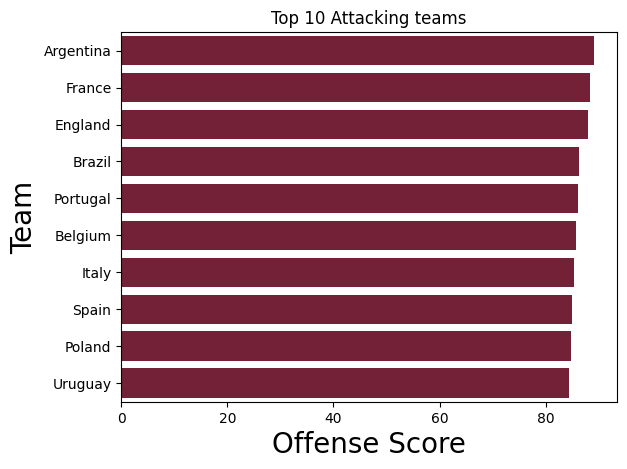

In [52]:
fifa_offense_top10_pd = fifa_offense_top10.toPandas()

sns.barplot(data=fifa_offense_top10_pd, x='offense_score', y='team', color="#7F1431")
plt.xlabel('Offense Score', size = 20)
plt.ylabel('Team', size = 20)
plt.title("Top 10 Attacking teams");

### Top 10 Midfield teams in the last FIFA date

In [53]:
# Select relevant columns and rename them for the home team
home = df.select(
    col("date"),
    col("home_team").alias("team"),
    col("home_team_mean_midfield_score").alias("midfield_score")
)

# Select relevant columns and rename them for the away team
away = df.select(
    col("date"),
    col("away_team").alias("team"),
    col("away_team_mean_midfield_score").alias("midfield_score")
)

# Combine the home and away DataFrames
fifa_midfield = home.union(away)

# Sort by date and team
fifa_midfield = fifa_midfield.orderBy(col("date").desc(), col("team"))

# Use a window function to get the first midfield score for each team
windowSpec = Window.partitionBy("team").orderBy(col("date").desc())
last_midfield = fifa_midfield.withColumn("row_num", row_number().over(windowSpec)).filter(col("row_num") == 1)

# Now find the top 10 midfield scores
fifa_midfield_top10 = last_midfield.orderBy(col("midfield_score").desc()).limit(10)

fifa_midfield_top10 = fifa_midfield_top10.select("team", "midfield_score")

# Show the top 10 midfield scores
fifa_midfield_top10.show()

+---------+--------------+
|     team|midfield_score|
+---------+--------------+
|  Germany|          87.8|
|   France|          86.8|
|    Spain|          86.0|
|  Belgium|          85.5|
|   Brazil|          85.5|
|    Italy|          84.5|
| Portugal|          84.5|
|  Croatia|          84.2|
|Argentina|          84.0|
|  England|          84.0|
+---------+--------------+



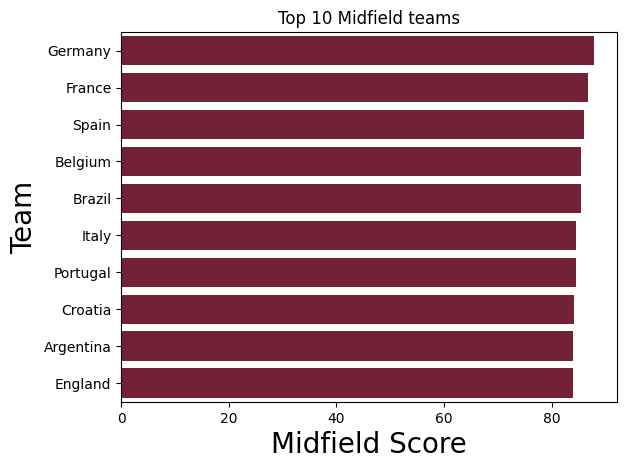

In [54]:
fifa_midfield_top10_pd = fifa_midfield_top10.toPandas()

sns.barplot(data=fifa_midfield_top10_pd, x='midfield_score', y='team', color="#7F1431")
plt.xlabel('Midfield Score', size = 20)
plt.ylabel('Team', size = 20)
plt.title("Top 10 Midfield teams");

### Top 10 defending teams in the last FIFA date

In [55]:
# Select relevant columns and rename them for the home team
home = df.select(
    col("date"),
    col("home_team").alias("team"),
    col("home_team_mean_defense_score").alias("defense_score")
)

# Select relevant columns and rename them for the away team
away = df.select(
    col("date"),
    col("away_team").alias("team"),
    col("away_team_mean_defense_score").alias("defense_score")
)

# Combine the home and away DataFrames
fifa_defense = home.union(away)

# Sort by date and team
fifa_defense = fifa_defense.orderBy(col("date").desc(), col("team"))

# Use a window function to get the most recent defense score for each team
windowSpec = Window.partitionBy("team").orderBy(col("date").desc())
last_defense = fifa_defense.withColumn("row_num", row_number().over(windowSpec)).filter(col("row_num") == 1)

# Now find the top 10 defense scores
fifa_defense_top10 = last_defense.orderBy(col("defense_score").desc()).limit(10)

fifa_defense_top10 = fifa_defense_top10.select("team", "defense_score")

# Show the top 10 defense scores
fifa_defense_top10.show()

+-----------+-------------+
|       team|defense_score|
+-----------+-------------+
|      Spain|         86.5|
|Netherlands|         85.2|
|   Portugal|         85.2|
|    England|         85.0|
|     Brazil|         84.8|
|     France|         84.2|
|      Italy|         84.2|
|    Germany|         84.0|
|  Argentina|         82.2|
|    Morocco|         81.2|
+-----------+-------------+



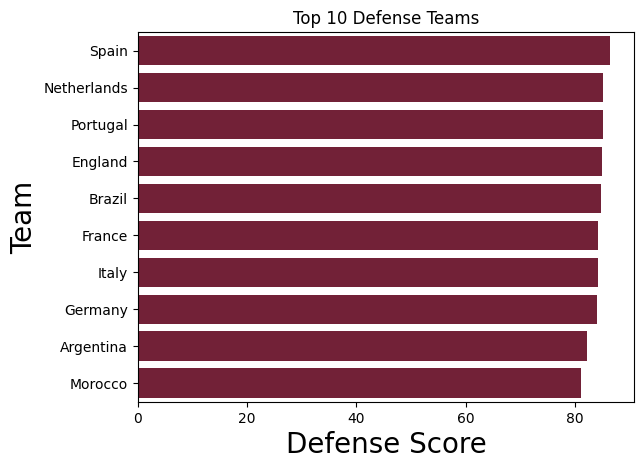

In [56]:
fifa_defense_top10_pd = fifa_defense_top10.toPandas()

# Use seaborn to create the barplot
sns.barplot(data=fifa_defense_top10_pd, x='defense_score', y='team', color="#7F1431")
plt.xlabel('Defense Score', size=20)
plt.ylabel('Team', size=20)
plt.title("Top 10 Defense Teams")
plt.show()

### Home teams advantage calculation

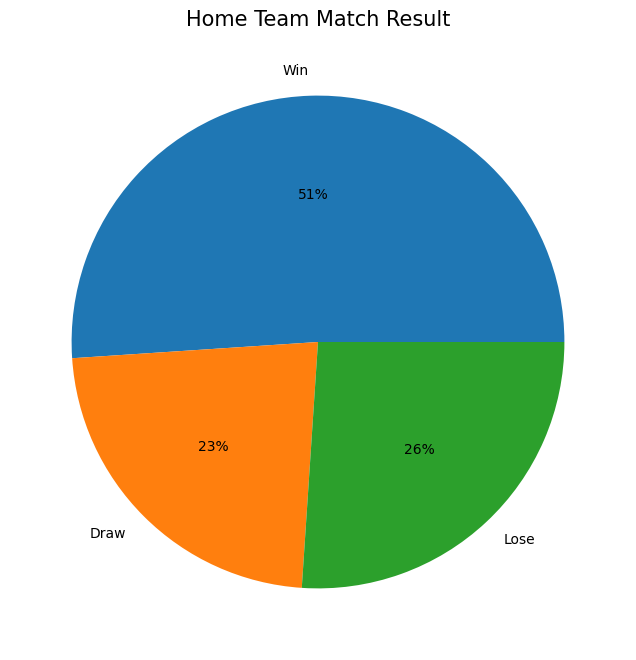

In [57]:
home_team_advantage = df.filter(col('neutral_location') == False) \
                         .groupBy('home_team_result') \
                         .count() \
                         .withColumn('percentage', col('count') / sum(col('count')).over(Window.partitionBy())) \
                         .toPandas()

# Prepare data for pie chart
results = home_team_advantage['home_team_result']
percentages = home_team_advantage['percentage'] * 100  # Convert to percentage

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(percentages, labels=results, autopct='%.0f%%')
plt.title('Home Team Match Result', fontsize=15)
plt.show()

Home team has an advantage over the away team.
Possible reasons are: Weather, confidence of players and fans.

# DATA PREPARATION + FEATURE ENGINEERING
- In this section, we'll complete the missing fields in the dataset and tidy up the data for teams that didn't qualify for the World Cup.
- Next, we'll utilize the correlation matrix to select the characteristics that will form the training dataset for our Machine Learning model.
- Finally, we'll leverage the ratings of the teams in their most recent matches to establish the "Last Team Scores" dataset, which will be used to predict the outcomes of the World Cup matches.

### FINDING NULLS IN DF AND FILLING THEM

In [58]:
def count_nulls(df):
    null_counts = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
    return null_counts

# Get null counts
null_counts_df = count_nulls(df)

# Show the result
null_counts_df.show()

+----+---------+---------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+----------+----+-------+----------------+---------+----------------+--------------------------+--------------------------+----------------------------+----------------------------+-----------------------------+----------------------------+----------------------------+-----------------------------+
|date|home_team|away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|tournament|city|country|neutral_location|shoot_out|home_team_result|home_team_goalkeeper_score|away_team_goalkeeper_score|home_team_mean_defense_score|home_team_mean_offense_score|home_team_mean_midfield_score|away_team_mean_defense_score|away_team_mean_offense_score|away_team_mean_midfield_score|
+----+--------

In [59]:
home_window = Window.partitionBy('home_team')
# Calculate the mean and fill NA for home goalkeeper scores, then round
df = df.withColumn('home_team_goalkeeper_score',
                   round(when(col('home_team_goalkeeper_score').isNull(),
                              mean('home_team_goalkeeper_score').over(home_window))
                         .otherwise(col('home_team_goalkeeper_score'))))

# Define a window specification over 'away_team'
away_window = Window.partitionBy('away_team')
# Calculate the mean and fill NA for away goalkeeper scores, then round
df = df.withColumn('away_team_goalkeeper_score',
                   round(when(col('away_team_goalkeeper_score').isNull(),
                              mean('away_team_goalkeeper_score').over(away_window))
                         .otherwise(col('away_team_goalkeeper_score'))))

In [60]:
# Define a window specification over 'home_team' for home defense scores
home_defense_window = Window.partitionBy('home_team')
# Calculate the mean, fill NA for home defense scores, and round
df = df.withColumn('home_team_mean_defense_score',
                   round(when(col('home_team_mean_defense_score').isNull(),
                              mean('home_team_mean_defense_score').over(home_defense_window))
                         .otherwise(col('home_team_mean_defense_score'))))

# Define a window specification over 'away_team' for away defense scores
away_defense_window = Window.partitionBy('away_team')
# Calculate the mean, fill NA for away defense scores, and round
df = df.withColumn('away_team_mean_defense_score',
                   round(when(col('away_team_mean_defense_score').isNull(),
                              mean('away_team_mean_defense_score').over(away_defense_window))
                         .otherwise(col('away_team_mean_defense_score'))))

In [61]:
# Define a window specification over 'home_team' for home offense scores
home_offense_window = Window.partitionBy('home_team')
# Calculate the mean, fill NA for home offense scores, and round
df = df.withColumn('home_team_mean_offense_score',
                   round(when(col('home_team_mean_offense_score').isNull(),
                              mean('home_team_mean_offense_score').over(home_offense_window))
                         .otherwise(col('home_team_mean_offense_score'))))

# Define a window specification over 'away_team' for away offense scores
away_offense_window = Window.partitionBy('away_team')
# Calculate the mean, fill NA for away offense scores, and round
df = df.withColumn('away_team_mean_offense_score',
                   round(when(col('away_team_mean_offense_score').isNull(),
                              mean('away_team_mean_offense_score').over(away_offense_window))
                         .otherwise(col('away_team_mean_offense_score'))))

In [62]:
# Define a window specification over 'home_team' for home midfield scores
home_midfield_window = Window.partitionBy('home_team')
# Calculate the mean, fill NA for home midfield scores, and round
df = df.withColumn('home_team_mean_midfield_score',
                   round(when(col('home_team_mean_midfield_score').isNull(),
                              mean('home_team_mean_midfield_score').over(home_midfield_window))
                         .otherwise(col('home_team_mean_midfield_score'))))

# Define a window specification over 'away_team' for away midfield scores
away_midfield_window = Window.partitionBy('away_team')
# Calculate the mean, fill NA for away midfield scores, and round
df = df.withColumn('away_team_mean_midfield_score',
                   round(when(col('away_team_mean_midfield_score').isNull(),
                              mean('away_team_mean_midfield_score').over(away_midfield_window))
                         .otherwise(col('away_team_mean_midfield_score'))))

In [63]:
# Get null counts
null_counts_df = count_nulls(df)

# Show the result
null_counts_df.show()

+----+---------+---------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+----------+----+-------+----------------+---------+----------------+--------------------------+--------------------------+----------------------------+----------------------------+-----------------------------+----------------------------+----------------------------+-----------------------------+
|date|home_team|away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|tournament|city|country|neutral_location|shoot_out|home_team_result|home_team_goalkeeper_score|away_team_goalkeeper_score|home_team_mean_defense_score|home_team_mean_offense_score|home_team_mean_midfield_score|away_team_mean_defense_score|away_team_mean_offense_score|away_team_mean_midfield_score|
+----+--------

In [64]:
# Teams are not available in FIFA game itself, so they are not less than average performing teams, so giving a average score of 50 for all.
df = df.fillna(50)

### Filter the teams participating in USA, Mexico, and Canada - World cup 2026

In [65]:
list_ranked = ['Argentina', 'France', 'Belgium', 'England', 'Brazil', 'Portugal', 'Netherlands', 'Spain', 'Italy', 'Croatia', 'USA', 'Colombia', 'Morocco', 'Mexico', 'Uruguay', 'Germany', 'Senegal', 'Japan', 'Switzerland', 'IR Iran', 'Denmark', 'Ukraine', 'Korea Republic', 'Australia', 'Austria', 'Hungary', 'Sweden', 'Poland', 'Wales', 'Nigeria', 'Ecuador', 'Peru']
final_df = df.filter(
    col("home_team").isin(list_ranked) | col("away_team").isin(list_ranked)
)

**Top 10 teams in FIFA World Cup 2026**

In [66]:
home = final_df.select(
    col("date"),
    col("home_team").alias("team"),
    col("home_team_fifa_rank").alias("rank")
)

# Select relevant columns and rename for away team
away = final_df.select(
    col("date"),
    col("away_team").alias("team"),
    col("away_team_fifa_rank").alias("rank")
)

rank = home.union(away)

windowSpec = Window.partitionBy("team").orderBy(col("date").desc())
rank = rank.withColumn("row_num", row_number().over(windowSpec)).filter(col("row_num") == 1).drop("row_num")

# Sort the result by rank and get the top 10
rank_top10 = rank.orderBy("rank").limit(10)

# Filter to include only teams that are in the list_ranked
list_ranked = ['Argentina', 'France', 'Belgium', 'England', 'Brazil', 'Portugal', 'Netherlands', 'Spain', 'Italy', 'Croatia', 'USA', 'Colombia', 'Morocco', 'Mexico', 'Uruguay', 'Germany', 'Senegal', 'Japan', 'Switzerland', 'IR Iran', 'Denmark', 'Ukraine', 'Korea Republic', 'Australia', 'Austria', 'Hungary', 'Sweden', 'Poland', 'Wales', 'Nigeria', 'Ecuador', 'Peru']
rank_top10 = rank_top10.filter(col("team").isin(list_ranked))

rank_top10 = rank_top10.select("team", "rank")

# Show the result
rank_top10.show()

+-----------+----+
|       team|rank|
+-----------+----+
|  Argentina|   1|
|     France|   2|
|    Belgium|   3|
|    England|   4|
|     Brazil|   5|
|   Portugal|   6|
|Netherlands|   7|
|      Spain|   8|
|      Italy|   9|
|    Croatia|  10|
+-----------+----+



**Top 10 teams with the highest winning percentage in FIFA World Cup 2026**

In [67]:
home_stats = final_df.groupBy("home_team").agg(
    (count(when(col("home_team_result") == "Win", True)) / count(lit(1)) * 100).alias("Home_win_Per")
).withColumnRenamed("home_team", "team")

# Away win percentage calculation
away_stats = final_df.groupBy("away_team").agg(
    (count(when(col("home_team_result") == "Lose", True)) / count(lit(1)) * 100).alias("Away_win_Per")
).withColumnRenamed("away_team", "team")

# Assuming rank_top10 is a DataFrame you've mentioned but not defined here
# You must ensure it has a column 'team' which matches teams in home_stats and away_stats

# Step 2: Join win percentages back to your rank_top10 DataFrame
rank_top10 = rank_top10.join(home_stats, on="team", how="left")
rank_top10 = rank_top10.join(away_stats, on="team", how="left")

# Step 3: Calculate the average win percentage
rank_top10 = rank_top10.withColumn("Average_win_Per", (col("Home_win_Per") + col("Away_win_Per")) / 2)

# Step 4: Order by average win percentage
rank_top10_Win = rank_top10.orderBy(col("Average_win_Per").desc())

# Show the DataFrame
rank_top10_Win.show()

+-----------+----+------------------+------------------+------------------+
|       team|rank|      Home_win_Per|      Away_win_Per|   Average_win_Per|
+-----------+----+------------------+------------------+------------------+
|      Spain|   8| 76.71957671957672|61.212121212121204| 68.96584896584896|
|     Brazil|   5|  77.6824034334764|              60.0|  68.8412017167382|
|     France|   2| 65.61085972850678| 57.04697986577181| 61.32891979713929|
|Netherlands|   7|61.979166666666664|  55.4054054054054| 58.69228603603604|
|  Argentina|   1| 68.42105263157895| 48.58757062146893|58.504311626523936|
|   Portugal|   6| 66.84782608695652| 49.34210526315789|  58.0949656750572|
|    England|   4| 63.91752577319587| 51.42857142857142| 57.67304860088365|
|      Italy|   9|59.798994974874375| 49.34210526315789| 54.57055011901613|
|    Croatia|  10| 59.74025974025974| 48.19277108433735| 53.96651541229855|
|    Belgium|   3| 59.50920245398773|45.588235294117645| 52.54871887405269|
+-----------

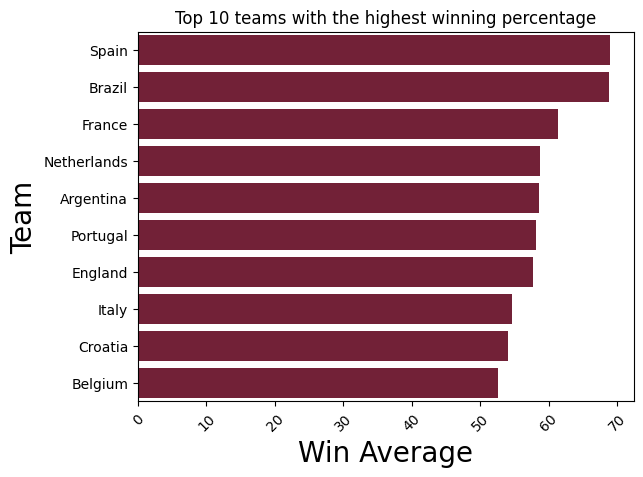

In [68]:
rank_top10_Win_pd = rank_top10_Win.toPandas()

# Create the barplot using seaborn
sns.barplot(data=rank_top10_Win_pd, x='Average_win_Per', y='team', color="#7F1431")

# Adjusting x-ticks (optional)
plt.xticks(rotation=45)  # Rotate labels to fit, if needed

# Setting labels and title
plt.xlabel('Win Average', size=20)
plt.ylabel('Team', size=20)
plt.title('Top 10 teams with the highest winning percentage')

# Show the plot
plt.show()

### Correlation Matrix

In [69]:
final_df = final_df.withColumn(
    'home_team_result',
    when(col('home_team_result') == 'Win', 1)
    .when(col('home_team_result') == 'Draw', 2)
    .when(col('home_team_result') == 'Lose', 0)
    .otherwise(col('home_team_result'))  # Handles any other unexpected values
)

In [70]:
final_df.groupBy('home_team_result').count().show()

+----------------+-----+
|home_team_result|count|
+----------------+-----+
|               0| 2609|
|               1| 4254|
|               2| 1970|
+----------------+-----+



Dropping unnecessary colums.

In [71]:
final_df = final_df.drop('date', 'home_team_continent', 'away_team_continent',
                         'home_team_total_fifa_points', 'away_team_total_fifa_points',
                         'home_team_score', 'away_team_score', 'tournament',
                         'city', 'country', 'neutral_location', 'shoot_out')

# Show the updated DataFrame schema to verify that columns are dropped
final_df.printSchema()

root
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- home_team_fifa_rank: integer (nullable = true)
 |-- away_team_fifa_rank: integer (nullable = true)
 |-- home_team_result: string (nullable = true)
 |-- home_team_goalkeeper_score: double (nullable = false)
 |-- away_team_goalkeeper_score: double (nullable = false)
 |-- home_team_mean_defense_score: double (nullable = false)
 |-- home_team_mean_offense_score: double (nullable = false)
 |-- home_team_mean_midfield_score: double (nullable = false)
 |-- away_team_mean_defense_score: double (nullable = false)
 |-- away_team_mean_offense_score: double (nullable = false)
 |-- away_team_mean_midfield_score: double (nullable = false)



In [72]:
final_df.columns

['home_team',
 'away_team',
 'home_team_fifa_rank',
 'away_team_fifa_rank',
 'home_team_result',
 'home_team_goalkeeper_score',
 'away_team_goalkeeper_score',
 'home_team_mean_defense_score',
 'home_team_mean_offense_score',
 'home_team_mean_midfield_score',
 'away_team_mean_defense_score',
 'away_team_mean_offense_score',
 'away_team_mean_midfield_score']

In [73]:
# Renaming multiple columns
final_df = final_df.withColumnRenamed("home_team", "Team1") \
                   .withColumnRenamed("away_team", "Team2") \
                   .withColumnRenamed("home_team_fifa_rank", "Team1_FIFA_RANK") \
                   .withColumnRenamed("away_team_fifa_rank", "Team2_FIFA_RANK") \
                   .withColumnRenamed("home_team_result", "Team1_Result") \
                   .withColumnRenamed("home_team_goalkeeper_score", "Team1_Goalkeeper_Score") \
                   .withColumnRenamed("away_team_goalkeeper_score", "Team2_Goalkeeper_Score") \
                   .withColumnRenamed("home_team_mean_defense_score", "Team1_Defense") \
                   .withColumnRenamed("home_team_mean_offense_score", "Team1_Offense") \
                   .withColumnRenamed("home_team_mean_midfield_score", "Team1_Midfield") \
                   .withColumnRenamed("away_team_mean_defense_score", "Team2_Defense") \
                   .withColumnRenamed("away_team_mean_offense_score", "Team2_Offense") \
                   .withColumnRenamed("away_team_mean_midfield_score", "Team2_Midfield")

# Verify the changes by printing the updated schema
final_df.printSchema()

root
 |-- Team1: string (nullable = true)
 |-- Team2: string (nullable = true)
 |-- Team1_FIFA_RANK: integer (nullable = true)
 |-- Team2_FIFA_RANK: integer (nullable = true)
 |-- Team1_Result: string (nullable = true)
 |-- Team1_Goalkeeper_Score: double (nullable = false)
 |-- Team2_Goalkeeper_Score: double (nullable = false)
 |-- Team1_Defense: double (nullable = false)
 |-- Team1_Offense: double (nullable = false)
 |-- Team1_Midfield: double (nullable = false)
 |-- Team2_Defense: double (nullable = false)
 |-- Team2_Offense: double (nullable = false)
 |-- Team2_Midfield: double (nullable = false)



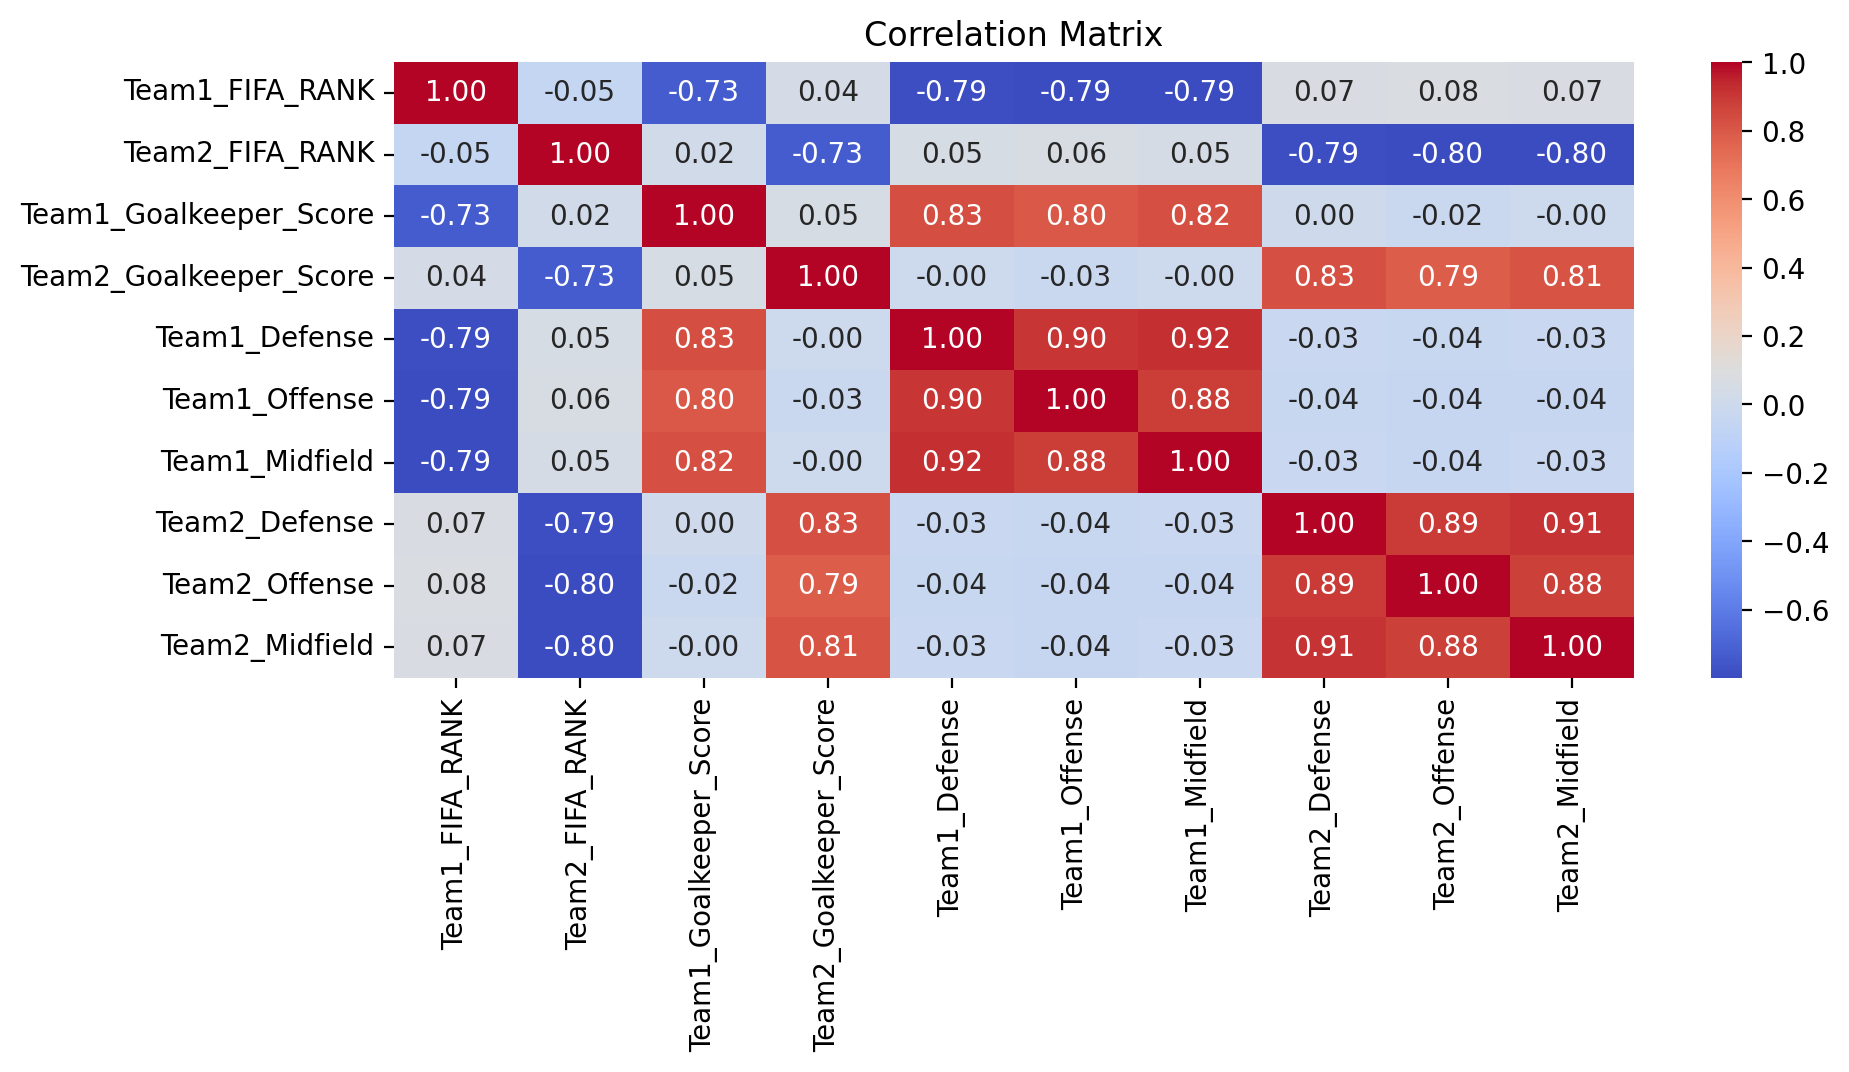

In [74]:
numeric_types = ['int', 'double', 'float', 'decimal']

# Filter DataFrame schema to find numeric columns
numeric_cols = [field.name for field in final_df.schema.fields if field.dataType.simpleString() in numeric_types]

# Select these columns in the DataFrame
numeric_df = final_df.select(*numeric_cols)

# Collect data to Pandas (ensure your dataset is small enough to fit in memory)
pandas_df = numeric_df.toPandas()

# Compute the correlation matrix
corr_matrix = pandas_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 4), dpi=200)  # Define the figure size and resolution
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # Use seaborn to create the heatmap
plt.title('Correlation Matrix')  # Title for the heatmap
plt.show()  # Display the plot


In [75]:
print("DataFrame Schema:")
final_df.printSchema()

# Count the number of rows in the DataFrame
row_count = final_df.count()
print("Total number of rows in DataFrame:", row_count)

# Optionally, show DataFrame column names and non-null count for each column if manageable size
print("DataFrame overview with non-null counts for each column (for smaller datasets):")
final_df.describe().show()

DataFrame Schema:
root
 |-- Team1: string (nullable = true)
 |-- Team2: string (nullable = true)
 |-- Team1_FIFA_RANK: integer (nullable = true)
 |-- Team2_FIFA_RANK: integer (nullable = true)
 |-- Team1_Result: string (nullable = true)
 |-- Team1_Goalkeeper_Score: double (nullable = false)
 |-- Team2_Goalkeeper_Score: double (nullable = false)
 |-- Team1_Defense: double (nullable = false)
 |-- Team1_Offense: double (nullable = false)
 |-- Team1_Midfield: double (nullable = false)
 |-- Team2_Defense: double (nullable = false)
 |-- Team2_Offense: double (nullable = false)
 |-- Team2_Midfield: double (nullable = false)

Total number of rows in DataFrame: 8833
DataFrame overview with non-null counts for each column (for smaller datasets):
+-------+-----------+-----------+------------------+------------------+------------------+----------------------+----------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|summary|

In [76]:
final_df.show()

+---------+-----------+---------------+---------------+------------+----------------------+----------------------+-------------+-------------+--------------+-------------+-------------+--------------+
|    Team1|      Team2|Team1_FIFA_RANK|Team2_FIFA_RANK|Team1_Result|Team1_Goalkeeper_Score|Team2_Goalkeeper_Score|Team1_Defense|Team1_Offense|Team1_Midfield|Team2_Defense|Team2_Offense|Team2_Midfield|
+---------+-----------+---------------+---------------+------------+----------------------+----------------------+-------------+-------------+--------------+-------------+-------------+--------------+
|    Japan|Afghanistan|             56|            151|           1|                  71.0|                  50.0|         73.0|         76.0|          77.0|         50.0|         50.0|          50.0|
|Argentina|    Albania|              5|             50|           1|                  77.0|                  69.0|         81.0|         87.0|          83.0|         73.0|         68.0|          6

Exporting the training dataset.

In [77]:
final_df.write.csv(path="/content/drive/MyDrive/Big Data/Data/training.csv", mode="overwrite", header=True)

### Creating "Last Team Scores" dataset
This dataset contains the qualifications of each team on the previous FIFA date and will be used to predict the World Cup matches.

In [78]:
last_goalkeeper = df.select(
    col('date'),
    col('home_team').alias('team'),
    col('home_team_goalkeeper_score').alias('goalkeeper_score')
).union(
    df.select(
        col('date'),
        col('away_team').alias('team'),
        col('away_team_goalkeeper_score').alias('goalkeeper_score')
    )
)

# Sort DataFrame by date (desc) and team (asc)
last_goalkeeper = last_goalkeeper.orderBy(col('date').desc(), col('team').asc())

# Filter by list of teams
list_2026 = ['Argentina', 'France', 'Belgium', 'England', 'Brazil', 'Portugal', 'Netherlands', 'Spain', 'Italy',
             'Croatia', 'USA', 'Colombia', 'Morocco', 'Mexico', 'Uruguay', 'Germany', 'Senegal', 'Japan',
             'Switzerland', 'IR Iran', 'Denmark', 'Ukraine', 'Korea Republic', 'Australia', 'Austria', 'Hungary',
             'Sweden', 'Poland', 'Wales', 'Nigeria', 'Ecuador', 'Peru']

last_goalkeeper = last_goalkeeper.filter(col('team').isin(list_2026))

# Get the most recent record per team
window_spec = Window.partitionBy('team').orderBy(col('date').desc())
goalkeeper_latest = last_goalkeeper.withColumn('rank', row_number().over(window_spec)).filter(col('rank') == 1).drop('rank', 'date')

# Similar steps for other score data
defense_scores = df.select(
    col('date'),
    col('home_team').alias('team'),
    col('home_team_mean_defense_score').alias('defense_score')
).union(
    df.select(
        col('date'),
        col('away_team').alias('team'),
        col('away_team_mean_defense_score').alias('defense_score')
    )
).orderBy(col('date').desc(), col('team').asc()).filter(col('team').isin(list_2026))

defense_latest = defense_scores.withColumn('rank', row_number().over(window_spec)).filter(col('rank') == 1).drop('rank', 'date')

offense_scores = df.select(
    col('date'),
    col('home_team').alias('team'),
    col('home_team_mean_offense_score').alias('offense_score')
).union(
    df.select(
        col('date'),
        col('away_team').alias('team'),
        col('away_team_mean_offense_score').alias('offense_score')
    )
).orderBy(col('date').desc(), col('team').asc()).filter(col('team').isin(list_2026))

offense_latest = offense_scores.withColumn('rank', row_number().over(window_spec)).filter(col('rank') == 1).drop('rank', 'date')

midfield_scores = df.select(
    col('date'),
    col('home_team').alias('team'),
    col('home_team_mean_midfield_score').alias('midfield_score')
).union(
    df.select(
        col('date'),
        col('away_team').alias('team'),
        col('away_team_mean_midfield_score').alias('midfield_score')
    )
).orderBy(col('date').desc(), col('team').asc()).filter(col('team').isin(list_2026))

midfield_latest = midfield_scores.withColumn('rank', row_number().over(window_spec)).filter(col('rank') == 1).drop('rank', 'date')

# Rank data assuming it's already available
rank_fifa = last_rank.filter(col('team').isin(list_2026))

# Merge all dataframes
fifa_26 = rank_fifa \
    .join(goalkeeper_latest, on='team', how='left') \
    .join(defense_latest, on='team', how='left') \
    .join(offense_latest, on='team', how='left') \
    .join(midfield_latest, on='team', how='left')

# Fill missing values with the mean
columns_to_fill = ['goalkeeper_score', 'defense_score', 'offense_score', 'midfield_score']
for col_name in columns_to_fill:
    mean_value = fifa_26.select(mean(col(col_name))).first()[0]
    fifa_26 = fifa_26.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))

# Round values
fifa_26 = fifa_26.withColumn('goalkeeper_score', round(col('goalkeeper_score'))) \
    .withColumn('defense_score', round(col('defense_score'))) \
    .withColumn('offense_score', round(col('offense_score'))) \
    .withColumn('midfield_score', round(col('midfield_score')))

# Show the resulting DataFrame
fifa_26.show(5)

+---------+----------+----+-----------+----------+----------------+-------------+-------------+--------------+
|     team|      date|rank|latest_date|row_number|goalkeeper_score|defense_score|offense_score|midfield_score|
+---------+----------+----+-----------+----------+----------------+-------------+-------------+--------------+
|Argentina|2023/06/05|   1| 2023/06/05|         1|            84.0|         82.0|         89.0|          84.0|
|Australia|2023/06/13|  24| 2023/06/13|         1|            77.0|         72.0|         72.0|          74.0|
|  Austria|2023/06/13|  25| 2023/06/13|         1|            74.0|         80.0|         77.0|          81.0|
|  Belgium|2023/06/14|   3| 2023/06/14|         1|            89.0|         81.0|         86.0|          86.0|
|   Brazil|2023/06/06|   5| 2023/06/06|         1|            89.0|         85.0|         86.0|          86.0|
+---------+----------+----+-----------+----------+----------------+-------------+-------------+--------------+
o

Exporting the "Last Team Scores" dataset.

In [79]:
# Specify the path where you want to save the CSV
output_path = "/content/drive/MyDrive/Big Data/Data/last_team_scores.csv"

# Save the DataFrame to CSV
qatar.write.csv(path=output_path, mode="overwrite", header=True)